# Volume 4: Timber Harvest
    Benj McMullin
    Math 439
    4/4/2024

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def initialize_all(y0, t0, t, n):
    """ An initialization routine for the different ODE solving
    methods in the lab. This initializes Y, T, and h. """
    if isinstance(y0, np.ndarray):
        Y = np.empty((n, y0.size)).squeeze()
    else:
        Y = np.empty(n)
    
    Y[0] = y0
    T = np.linspace(t0, t, n)
    h = float(t - t0) / (n - 1)
    return Y, T, h

def RK4(f, y0, t0, t, n):
    """ Use the RK4 method to compute an approximate solution
    to the ODE y' = f(t, y) at n equispaced parameter values from t0 to t
    with initial conditions y(t0) = y0.
    
    y0 is assumed to be either a constant or a one-dimensional numpy array.
    t and t0 are assumed to be constants.
    f is assumed to accept three arguments.
    The first is a constant giving the value of t.
    The second is a one-dimensional numpy array of the same size as y.
    The third is an index to the other arrays.
    
    This function returns an array Y of shape (n,) if
    y is a constant or an array of size 1.
    It returns an array of shape (n, y.size) otherwise.
    In either case, Y[i] is the approximate value of y at
    the i'th value of np.linspace(t0, t, n).
    """
    Y,T,h = initialize_all(y0,t0,t,n)
    for i in range(n-1):
        K1 = f(T[i],Y[i],i)
        K2 = f(T[i]+h/2.,Y[i]+h/2.*K1,i)
        K3 = f(T[i]+h/2.,Y[i]+h/2.*K2,i)
        K4 = f(T[i+1],Y[i]+h*K3,i)
        Y[i+1] = Y[i] + h/6.*(K1+2*K2 +2*K3+K4)
    return Y

# Problem 1

Write a function that takes as input scalars $x_{0}$, $k$, $r$, and a final time $T$ and solves the optimal control problem stated above using the RK4 method described above. The function will return the time-step and the values of x and u at the specific time-steps.

In [3]:
def solve_tree_harvest(x0, k, r, T, N=1000, delta=0.001):
    """
    Solves for the optimal control for the tree harvesting problem 
    with the given parameters.
    
    Parameters:
        x0 - initial amount of timber being produced
        k - investment growth rate
        r - interest rate
        T - final time
        N - number of time steps
        delta - error tolerance for convergence
    Returns:
        t ((N+1), ndarray) - timesteps
        x ((N+1), ndarray) - timber production values
        u ((N+1), ndarray) - the optimal control
    """
    # Discretize time
    t = np.linspace(0, T, N + 1)
    h = T / N
    h2 = h / 2
    
    # Initialize arrays
    x = np.zeros(N + 1)
    alpha = np.zeros(N + 1)
    u = np.zeros(N + 1)
    
    # Define functions
    f = lambda x, u: k * u * x
    g = lambda t, alpha, u: u * (np.exp(-r * t) - k * alpha) - np.exp(-r * t)
    
    # Set initial conditions
    x[0] = x0
    alpha[-1] = 0
    
    # Main loop
    while True:
        oldu = u.copy()
        oldx = x.copy()
        oldalpha = alpha.copy()
        
        # Integrate forward for x using Runge-Kutta 4th order method
        for i in range(N):
            K1 = f(x[i], u[i])
            K2 = f(x[i] + h2 * K1, (u[i] + u[i + 1]) / 2)
            K3 = f(x[i] + h2 * K2, (u[i] + u[i + 1]) / 2)
            K4 = f(x[i] + h * K3, u[i + 1])
            x[i + 1] = x[i] + (h / 6) * (K1 + 2 * K2 + 2 * K3 + K4)
        
        # Integrate backward for alpha using Runge-Kutta 4th order method
        for i in range(N):
            j = N - i
            K1 = g(t[j], alpha[j], u[j])
            K2 = g(t[j] - h2, alpha[j] - h2 * K1, (u[j] + u[j - 1]) / 2)
            K3 = g(t[j] - h2, alpha[j] - h2 * K2, (u[j] + u[j - 1]) / 2)
            K4 = g(t[j] - h, alpha[j] - h * K3, u[j - 1])
            alph = (h / 6) * (K1 + 2 * K2 + 2 * K3 + K4)
            alpha[j - 1] = alpha[j] - alph
        
        # Update control variable u based on the sign of phi
        phi = x * (k * alpha - np.exp(-r * t))
        u[phi > 0] = 1
        
        # Check for convergence
        if (np.sum(np.abs(oldu - u)) < delta * np.sum(np.abs(u))
            and np.sum(np.abs(oldx - x)) < delta * np.sum(np.abs(x))
            and np.sum(np.abs(oldalpha - alpha)) < delta * np.sum(np.abs(alpha))):
            break
            
    return t, x, u

# Problem 2

Using your function from problem 1, plot time vs. timber production ($x$) and plot time vs. reinvestment percentage ($u$) for the following values: $x_{0} = 100$, $k = 1$, $r = 0$, and $T = 5$.


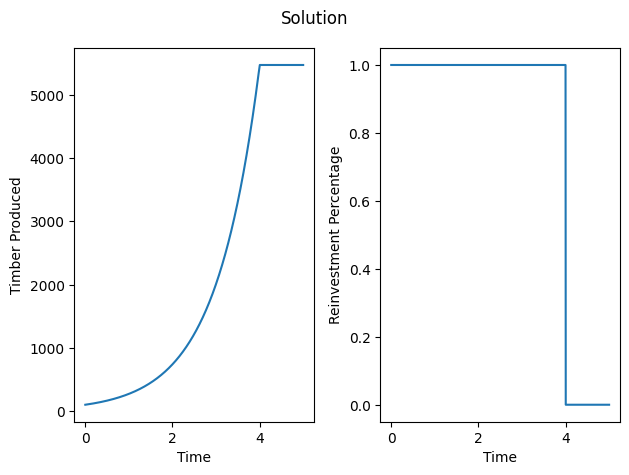

In [4]:
# Set initial conditions and parameters
x0 = 100  # Initial timber produced
k = 1     # Growth rate constant
r = 0     # Discount rate (interest rate)
T = 5     # Time horizon

# Solve the tree harvest problem using the provided function
t, x, u = solve_tree_harvest(x0, k, r, T)

# Plot the results
plt.subplot(121)  # Subplot 1 for timber produced over time
plt.plot(t, x)
plt.xlabel("Time")
plt.ylabel("Timber Produced")
plt.subplot(122)  # Subplot 2 for reinvestment percentage over time
plt.plot(t, u)
plt.xlabel("Time")
plt.ylabel("Reinvestment Percentage")
plt.suptitle("Solution")  # Overall title for the plot
plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()  # Display the plot

# Problem 3

Plot the same graphs that you did in problem 2, but instead for the following values: $x_{0} = 100$, $k = 0.3$, $r = 0.05$, and $T = 5$. At what time does the switching point occur?

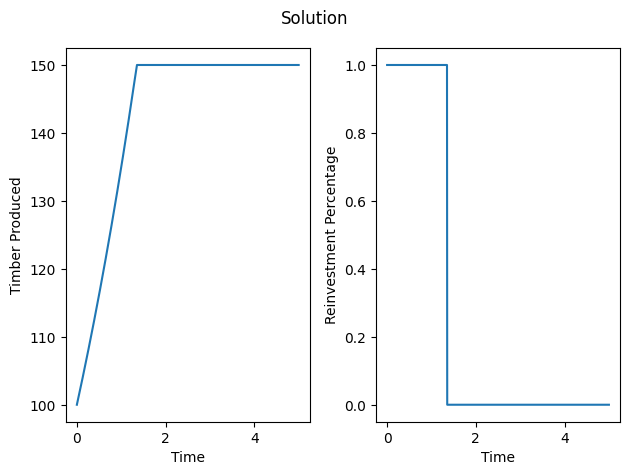

In [5]:
# Set initial conditions and parameters
x0 = 100    # Initial timber produced
k = 0.3     # Growth rate constant
r = 0.05    # Discount rate (interest rate)
T = 5       # Time horizon

# Solve the tree harvest problem using the provided function
t, x, u = solve_tree_harvest(x0, k, r, T)

# Plot the results
plt.subplot(121)  # Subplot 1 for timber produced over time
plt.plot(t, x)
plt.xlabel("Time")
plt.ylabel("Timber Produced")
plt.subplot(122)  # Subplot 2 for reinvestment percentage over time
plt.plot(t, u)
plt.xlabel("Time")
plt.ylabel("Reinvestment Percentage")
plt.suptitle("Solution")  # Overall title for the plot
plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()  # Display the plot

# Problem 4

Now use the same parameters as in problem 3, but vary the initial value of the timber production capacity ($x_{0}$). You should try a smaller value, a slightly larger value, and fairly larger value for $x_{0}$. What do you notice about the optimal controls (are they the same or are they different)?


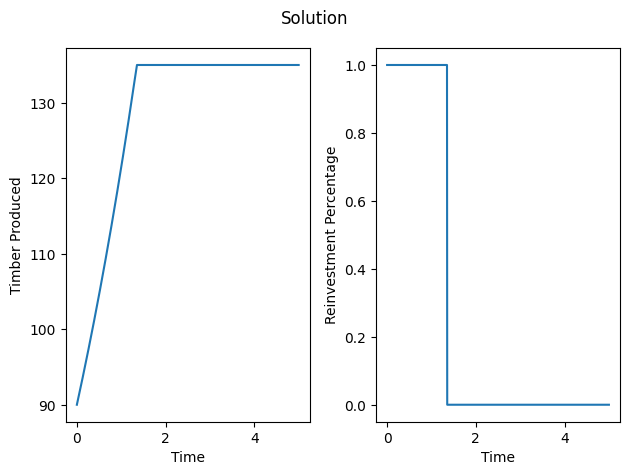

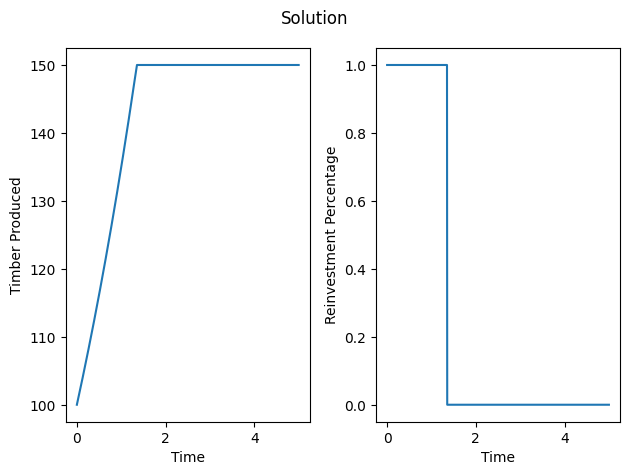

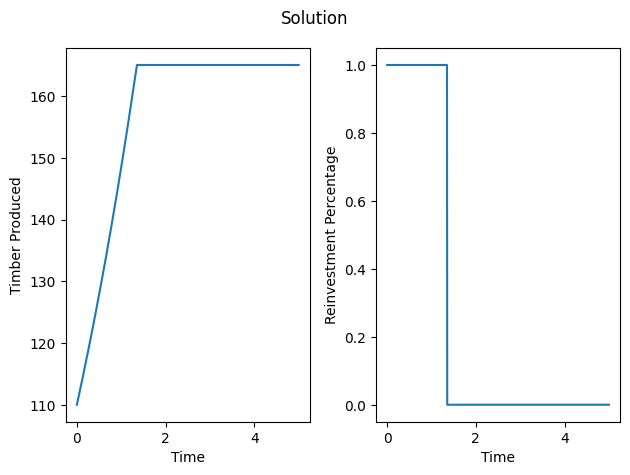

In [6]:
# Iterate over different initial timber produced values
for x0 in [90, 100, 110]:
    # Set growth rate constant, discount rate, and time horizon
    k = 0.3
    r = 0.05
    T = 5
    
    # Solve the tree harvest problem for the current initial timber produced value
    t, x, u = solve_tree_harvest(x0, k, r, T)

    # Plot the results
    plt.subplot(121)  # Subplot 1 for timber produced over time
    plt.plot(t, x)
    plt.xlabel("Time")
    plt.ylabel("Timber Produced")
    plt.subplot(122)  # Subplot 2 for reinvestment percentage over time
    plt.plot(t, u)
    plt.xlabel("Time")
    plt.ylabel("Reinvestment Percentage")
    plt.suptitle("Solution")  # Overall title for the plot
    plt.tight_layout()  # Adjust layout to prevent overlapping labels
    plt.show()  # Display the plot